In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
from core.model_load_utils import load_model_transform, MODEL_LAYER_FILTERS, LAYER_ABBREVIATION_MAPS
from neural_regress.feature_reduction_lib import FEATURE_REDUCTION_DEFAULTS, LAYER_TRANSFORM_FILTERS
from neural_regress.regress_lib import record_features, perform_regression_sweeplayer, perform_regression_sweeplayer_RidgeCV
from neural_regress.regress_lib import sweep_regressors, transform_features2Xdict_new, transform_features2Xdict, RidgeCV, apply_feature_transforms
from neural_regress.regress_eval_lib import format_result_df, plot_result_df_per_layer, construct_result_df_masked, \
    compute_pred_dict_D2_per_unit, format_result_df_tuple_index
from neural_regress.regress_lib import sweep_regressors
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch
#%% Utility Functions
from core.data_utils import load_from_hdf5, load_neural_data, load_neural_trial_resp_tensor, create_response_tensor, parse_image_fullpaths

In [3]:
import os
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

from core.data_utils import load_from_hdf5, load_neural_data, load_neural_trial_resp_tensor, create_response_tensor, parse_image_fullpaths, extract_neural_data_dict_2025apr
encoding_stim_dir = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Stimuli/encodingstimuli_apr2025"
dataroot = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Ephys_Data"
model_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_models/"
# subject_id = "red_20250428-20240429"
subject_id, filename = ("red_20250428-20250430", "red_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5")
data_path = join(dataroot, filename)
data = load_from_hdf5(data_path)

data = load_from_hdf5(data_path)
data_dict = extract_neural_data_dict_2025apr(data)
data_dict['image_fps'] = parse_image_fullpaths(data_dict["stimulus_names"], [encoding_stim_dir], arbitrary_format=True)

All stimulus files were found


In [4]:
model_output_dir = join(model_root, subject_id, "model_outputs_pca4all")
synopsis_dir = join(model_root, subject_id, "synopsis")
os.makedirs(synopsis_dir, exist_ok=True)

In [20]:
modelname = "dinov2_vitb14_reg"
model_names = [
    "dinov2_vitb14_reg",
    "clipag_vitb32",
    "siglip2_vitb16",
    "radio_v2.5-b",
    "resnet50_robust",
    "resnet50_clip",
    "resnet50_dino",
    "resnet50",
    "regnety_640",
    "AlexNet_training_seed_01",
    # "ReAlnet01",
]
for modelname in model_names:
    pred_meta_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl")
    assert os.path.exists(pred_meta_path)
    result_df_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV_df.pkl")
    assert os.path.exists(result_df_path)
    pred_meta = pkl.load(open(pred_meta_path, "rb"))
    result_df = pd.read_pickle(result_df_path)

### Demo

In [42]:
# modelname = "regnety_640"
modelname = "resnet50"
pred_meta_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl")
assert os.path.exists(pred_meta_path)
result_df_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV_df.pkl")
assert os.path.exists(result_df_path)
result_df = pd.read_pickle(result_df_path)
pred_meta = pkl.load(open(pred_meta_path, "rb"))
D2_per_unit_train_dict = pred_meta["D2_per_unit_train_dict"]
D2_per_unit_test_dict = pred_meta["D2_per_unit_test_dict"]
D2_per_unit_dict = pred_meta["D2_per_unit_dict"]
pred_dict = pred_meta["pred_dict"]

In [43]:
# Get indices of top 5 most reliable neurons
topk_reliable_chan_idx = np.argsort(data_dict['reliability'])[-5:][::-1]
topk_reliability = data_dict['reliability'][topk_reliable_chan_idx]
print(topk_reliability)
print(topk_reliable_chan_idx)


[0.8390227  0.82361527 0.80060784 0.78369492 0.77112247]
[15  9  0 19  2]


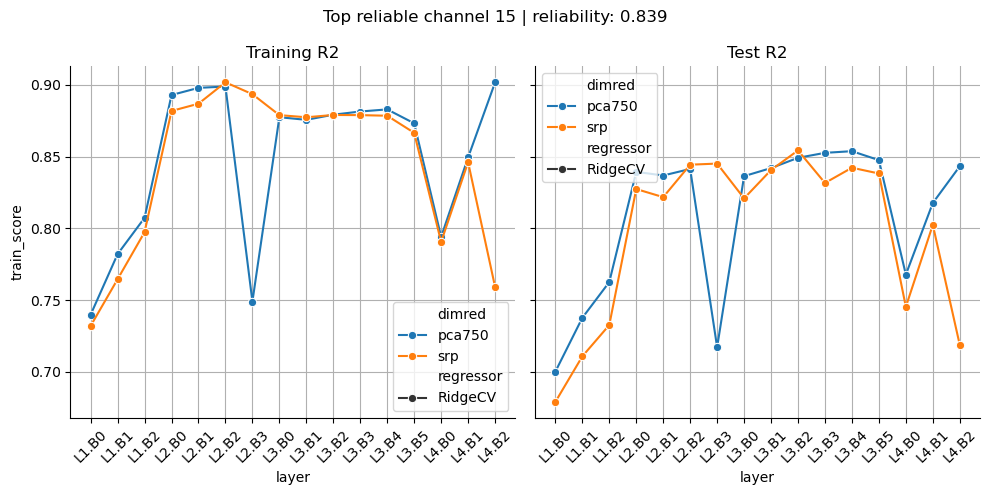

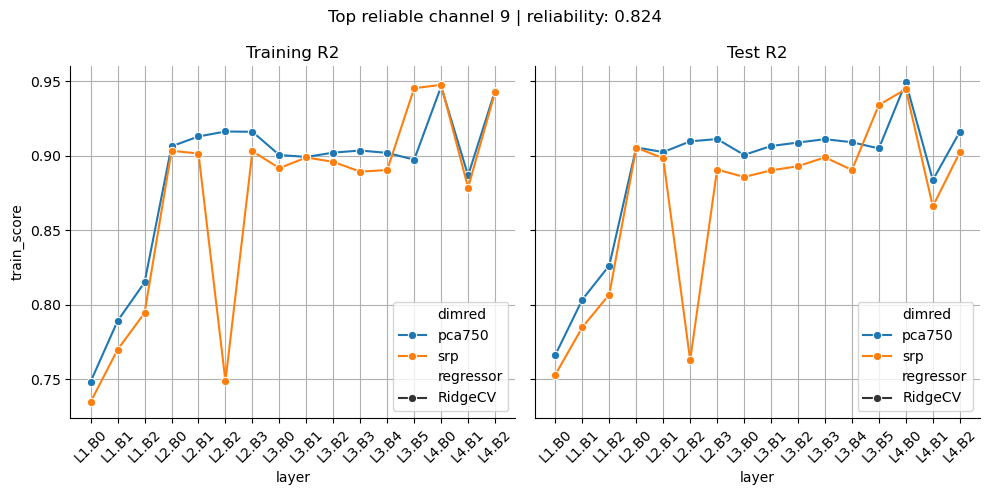

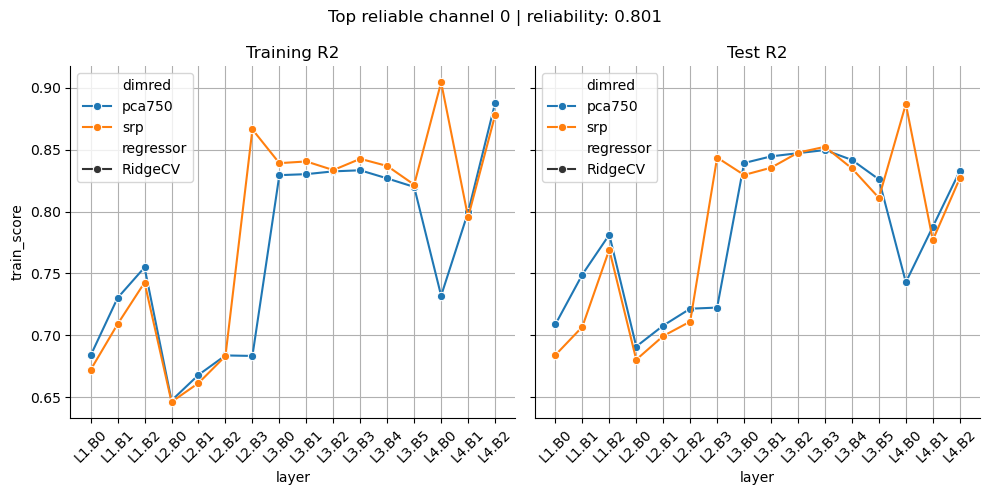

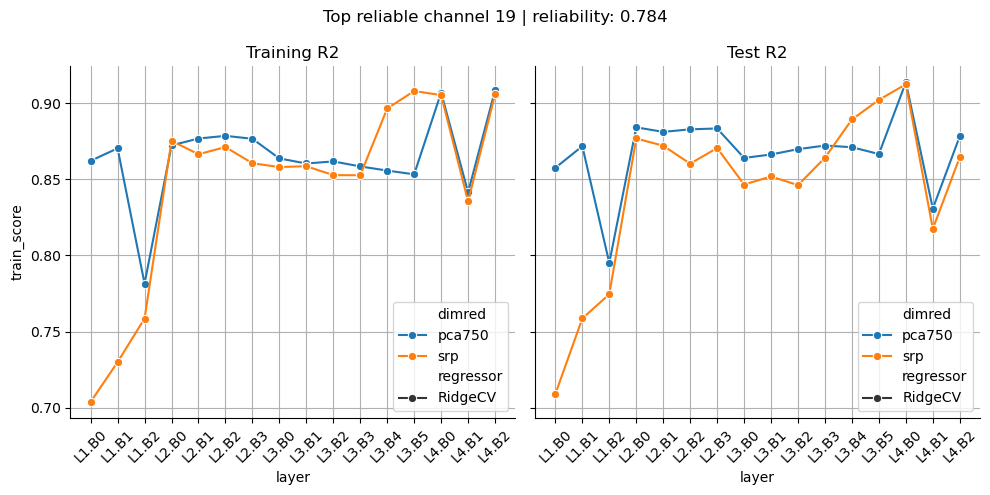

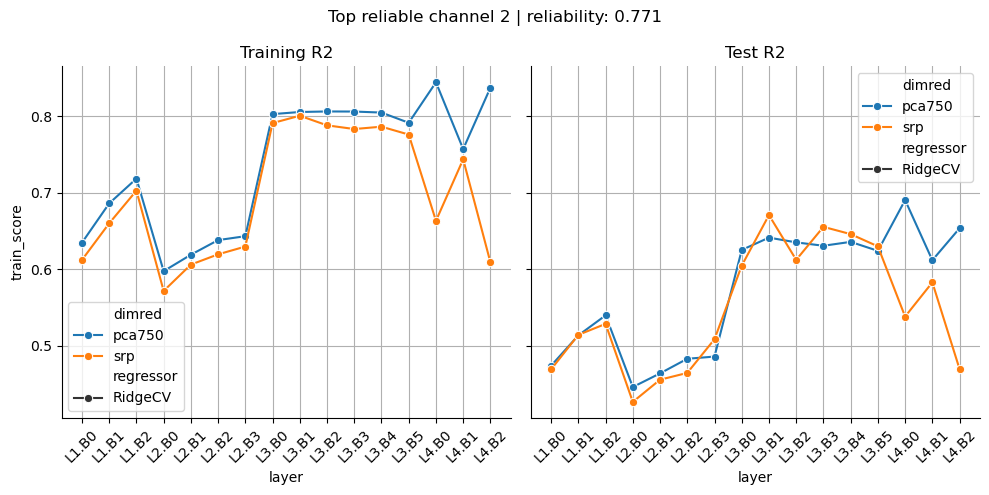

In [44]:
for idx in topk_reliable_chan_idx:
    single_chan_result_df = construct_result_df_masked(D2_per_unit_train_dict, D2_per_unit_test_dict, mask=idx)
    fig = plot_result_df_per_layer(single_chan_result_df, grid=True, sharey=True)
    fig.suptitle(f"{modelname} | Top reliable channel {idx} | reliability: {data_dict['reliability'][idx]:.3f}")
    plt.tight_layout()
    fig.show()
    # fig.savefig(f"single_chan_result_df_{idx}.png")

### Synopsis plot across the top channels

In [15]:
model_names = [
    "dinov2_vitb14_reg",
    "clipag_vitb32",
    "siglip2_vitb16",
    "radio_v2.5-b",
    "resnet50_robust",
    "resnet50_clip",
    "resnet50_dino",
    "resnet50",
    "regnety_640",
    "AlexNet_training_seed_01",
    # "ReAlnet01",
]
reliability = data_dict['reliability']
channel_mask = reliability > 0.7
top5_chan_result_df_col = []
for modelname in model_names:
    pred_meta_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl")
    assert os.path.exists(pred_meta_path)
    result_df_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV_df.pkl")
    assert os.path.exists(result_df_path)
    pred_meta = pkl.load(open(pred_meta_path, "rb"))
    result_df = pd.read_pickle(result_df_path)
    D2_per_unit_train_dict = pred_meta["D2_per_unit_train_dict"]
    D2_per_unit_test_dict = pred_meta["D2_per_unit_test_dict"]
    top5_chan_result_df = construct_result_df_masked(D2_per_unit_train_dict, D2_per_unit_test_dict, mask=channel_mask)
    top5_chan_result_df = format_result_df_tuple_index(top5_chan_result_df, )
    top5_chan_result_df["modelname"] = modelname
    top5_chan_result_df["layer_abbrev"] = top5_chan_result_df["layer"].map(LAYER_ABBREVIATION_MAPS[modelname])
    top5_chan_result_df_col.append(top5_chan_result_df)
top5_chan_result_df = pd.concat(top5_chan_result_df_col, axis=0)
# top5_chan_result_df.to_csv(join(model_output_dir, f"{subject_id}_top5_chan_result_df.csv"))

In [16]:
top5_chan_result_df

,layer,dimred,regressor,layer_dimred,train_score,test_score,modelname,layer_abbrev
0,.blocks.NestedTensorBlock0,pca750,RidgeCV,.blocks.NestedTensorBlock0_pca750,0.903503,0.279759,dinov2_vitb14_reg,B0
1,.blocks.NestedTensorBlock0,srp,RidgeCV,.blocks.NestedTensorBlock0_srp,0.745287,0.246394,dinov2_vitb14_reg,B0
2,.blocks.NestedTensorBlock1,pca750,RidgeCV,.blocks.NestedTensorBlock1_pca750,0.848967,0.321790,dinov2_vitb14_reg,B1
3,.blocks.NestedTensorBlock1,srp,RidgeCV,.blocks.NestedTensorBlock1_srp,0.766969,0.278790,dinov2_vitb14_reg,B1
4,.blocks.NestedTensorBlock2,pca750,RidgeCV,.blocks.NestedTensorBlock2_pca750,0.856823,0.339648,dinov2_vitb14_reg,B2
...,...,...,...,...,...,...,...,...
31,.classifier.Conv2d3,srp,RidgeCV,.classifier.Conv2d3_srp,0.615109,0.224952,AlexNet_training_seed_01,fc7
32,.classifier.ReLU4,pca750,RidgeCV,.classifier.ReLU4_pca750,0.562795,0.223311,AlexNet_training_seed_01,relu7
33,.classifier.ReLU4,srp,RidgeCV,.classifier.ReLU4_srp,0.563355,0.223844,AlexNet_training_seed_01,relu7
34,.classifier.Conv2d6,pca750,RidgeCV,.classifier.Conv2d6_pca750,0.489224,0.200245,AlexNet_training_seed_01,fc8


/tmp/ipykernel_1059687/2078273988.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_per_model = top5_chan_result_df.groupby('modelname').apply(


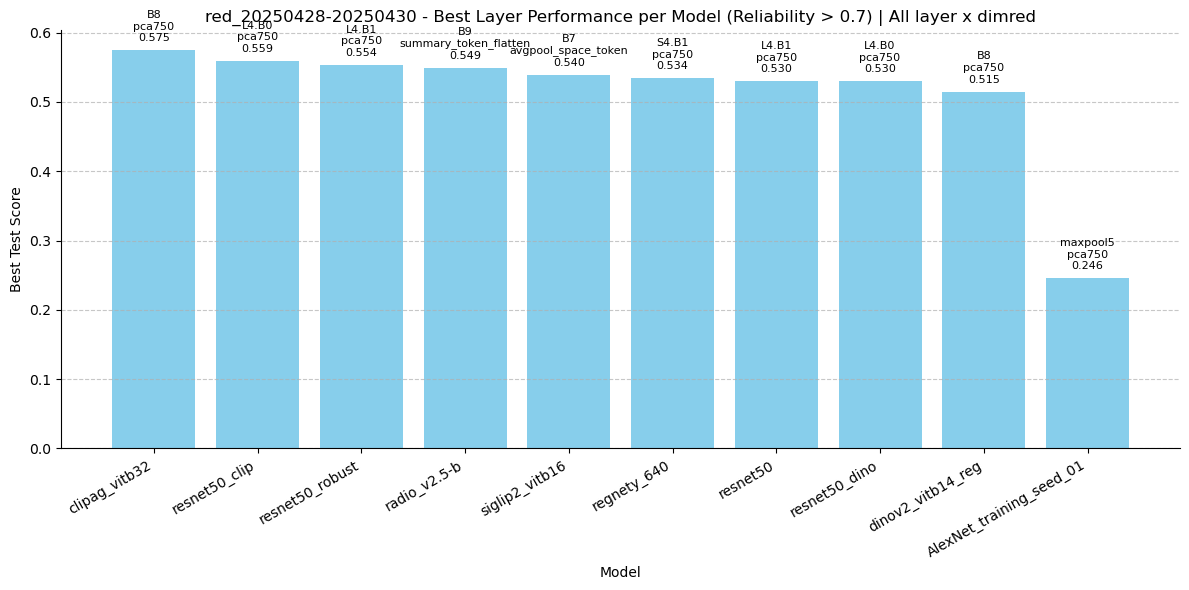

In [ ]:
# Find the best layer/dimred/regressor combination for each model
best_per_model = top5_chan_result_df.groupby('modelname').apply(
    lambda x: x.loc[x['test_score'].idxmax()]
).reset_index(drop=True)

# Sort by test_score for better visualization
best_per_model = best_per_model.sort_values('test_score', ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(best_per_model['modelname'], best_per_model['test_score'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Best Test Score')
plt.title(f'{subject_id} - Best Layer Performance per Model (Reliability > 0.7) | All layer x dimred')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add the best layer/dimred info as text on top of each bar
for i, bar in enumerate(bars):
    layer = best_per_model.iloc[i]['layer_abbrev']
    dimred = best_per_model.iloc[i]['dimred']
    score = best_per_model.iloc[i]['test_score']
    
    # Truncate layer name if too long
    if len(layer) > 20:
        layer = layer[:17] + "..."
        
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        bar.get_height() + 0.01, 
        f"{layer}\n{dimred}\n{score:.3f}", 
        ha='center', va='bottom', 
        fontsize=8, rotation=0
    )
plt.tight_layout()
plt.show()

### Function version of plots

In [5]:
from circuit_toolkit.plot_utils import saveallforms
import seaborn as sns

In [6]:
def sweep_combine_result_df(model_output_dir, subject_id, channel_mask=None, model_names=None):
    if model_names is None:
        model_names = [
            "dinov2_vitb14_reg",
            "clipag_vitb32",
            "siglip2_vitb16",
            "radio_v2.5-b",
            "resnet50_robust",
            "resnet50_clip",
            "resnet50_dino",
            "resnet50",
            "regnety_640",
            "AlexNet_training_seed_01",
            # "ReAlnet01",
        ]
    
    top5_chan_result_df_col = []
    for modelname in model_names:
        pred_meta_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl")
        if not os.path.exists(pred_meta_path):
            print(f"pred_meta_path {pred_meta_path} does not exist, skipping {modelname}")
            continue
        result_df_path = join(model_output_dir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV_df.pkl")
        if not os.path.exists(result_df_path):
            print(f"result_df_path {result_df_path} does not exist, skipping {modelname}")
            continue
        
        pred_meta = pkl.load(open(pred_meta_path, "rb"))
        result_df = pd.read_pickle(result_df_path)
        D2_per_unit_train_dict = pred_meta["D2_per_unit_train_dict"]
        D2_per_unit_test_dict = pred_meta["D2_per_unit_test_dict"]
        top5_chan_result_df = construct_result_df_masked(D2_per_unit_train_dict, D2_per_unit_test_dict, mask=channel_mask)
        top5_chan_result_df = format_result_df_tuple_index(top5_chan_result_df, )
        top5_chan_result_df["modelname"] = modelname
        top5_chan_result_df["layer_abbrev"] = top5_chan_result_df["layer"].map(LAYER_ABBREVIATION_MAPS[modelname])
        top5_chan_result_df_col.append(top5_chan_result_df)
    
    if top5_chan_result_df_col:
        return pd.concat(top5_chan_result_df_col, axis=0)
    else:
        return pd.DataFrame()


In [15]:
# Create a function that returns a figure
def plot_best_per_model(best_per_model, subtitle=f'{subject_id} - Best Layer Performance per Model (Reliability > 0.7)', figsize=(12, 6), descending=True, color='skyblue'):
    if descending:
        best_per_model = best_per_model.sort_values('test_score', ascending=False)
    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(best_per_model['modelname'], best_per_model['test_score'], color=color)
    ax.set_xlabel('Model')
    ax.set_ylabel('Best Test Score')
    ax.set_title(subtitle)
    plt.xticks(rotation=30, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    # Add the best layer/dimred info as text on top of each bar
    for i, bar in enumerate(bars):
        layer = best_per_model.iloc[i]['layer_abbrev']
        dimred = best_per_model.iloc[i]['dimred']
        score = best_per_model.iloc[i]['test_score']
        
        # Truncate layer name if too long
        if len(layer) > 20:
            layer = layer[:17] + "..."
            
        ax.text(
            bar.get_x() + bar.get_width()/2, 
            bar.get_height() + 0.01, 
            f"{layer}\n{dimred}\n{score:.3f}", 
            ha='center', va='bottom', 
            fontsize=8, rotation=0
        )
    fig.tight_layout()
    return fig

# Create a function that returns a figure
def plot_layer_sweep_per_model(result_df_all, subtitle=f'{subject_id} - Best Layer Performance per Model (Reliability > 0.7)', figsize=(12, 6), descending=True):

    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(best_per_model['modelname'], best_per_model['test_score'], color='skyblue')
    ax.set_xlabel('Model')
    ax.set_ylabel('Best Test Score')
    ax.set_title(subtitle)
    plt.xticks(rotation=30, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    # Add the best layer/dimred info as text on top of each bar
    for i, bar in enumerate(bars):
        layer = best_per_model.iloc[i]['layer_abbrev']
        dimred = best_per_model.iloc[i]['dimred']
        score = best_per_model.iloc[i]['test_score']
        
        # Truncate layer name if too long
        if len(layer) > 20:
            layer = layer[:17] + "..."
            
        ax.text(
            bar.get_x() + bar.get_width()/2, 
            bar.get_height() + 0.01, 
            f"{layer}\n{dimred}\n{score:.3f}", 
            ha='center', va='bottom', 
            fontsize=8, rotation=0
        )
    fig.tight_layout()
    return fig

In [8]:
def plot_model_layer_comparison(result_df, suptitle, rows=3, cols=4, figsize=(20, 15)):
    """
    Create a multi-panel figure with one subplot per model showing test score as function of layer.
    
    Parameters:
    -----------
    result_df : pandas.DataFrame
        DataFrame containing the results with columns: modelname, layer_abbrev, test_score, dimred, regressor
    suptitle : str
        Suptitle for the figure
    rows : int, optional
        Number of rows in the subplot grid (default: 3)
    cols : int, optional
        Number of columns in the subplot grid (default: 4)
    figsize : tuple, optional
        Figure size in inches (width, height) (default: (20, 15))
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    # Create a multi-panel figure with one subplot per model showing test score as function of layer
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True, sharey='all')
    axes = axes.flatten()
    
    # Get unique models
    models = result_df['modelname'].unique()
    
    # Plot each model in its own subplot
    for i, model in enumerate(models):
        if i >= len(axes):  # Skip if we have more models than subplots
            break
        ax = axes[i]
        sns.lineplot(
            data=result_df.query("modelname == @model"),
            x='layer_abbrev', y='test_score', hue='dimred', style='regressor',
            marker='o', markersize=8, linewidth=2,
            ax=ax, 
        )
        ax.grid(True)
        ax.set_title(model, fontsize=14)
        ax.set_xlabel('Layer')
        ax.set_ylabel('Test Score (R²)')
        # Ensure y-axis ticks are visible
        ax.tick_params(axis='y', which='both', left=True, labelleft=True)
        # ax.set_ylim(0, layer_scores['test_score'].max() * 1.1)  # Add 10% padding
        # rotate and align in one go
        ax.tick_params(axis='x', rotation=40)        # rotate them
        for lbl in ax.get_xticklabels():             # grab the Text objects
            lbl.set_ha('right')                      # set horizontal alignment

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(suptitle, 
                 fontsize=16, y=0.98)
    plt.tight_layout()
    
    return fig



In [38]:
# Use the function with reliability threshold
reliability = data_dict['reliability']
threshold = 0.7
channel_mask = reliability > threshold
top5_chan_result_df = sweep_combine_result_df(model_output_dir, subject_id, channel_mask)
top5_chan_result_df.to_csv(join(synopsis_dir, f"{subject_id}_top5_chan_all_models_result_df_synopsis_reliability_{threshold}.csv"))

/tmp/ipykernel_1059687/602836255.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_per_model = top5_chan_result_df.query("'pca750' in dimred").groupby('modelname').apply(


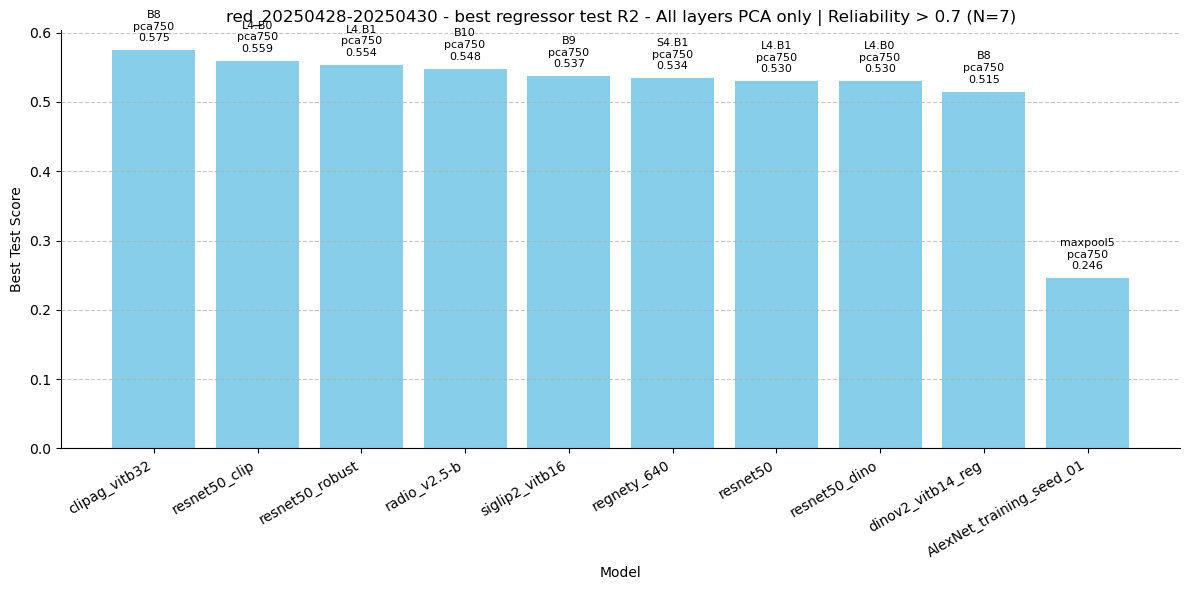

In [39]:
# Find the best layer/dimred/regressor combination for each model
best_per_model = top5_chan_result_df.query("'pca750' in dimred").groupby('modelname').apply(
    lambda x: x.loc[x['test_score'].idxmax()]
).reset_index(drop=True)
# Generate and display the figure
fig = plot_best_per_model(best_per_model, f"{subject_id} - best regressor test R2 - All layers PCA only | Reliability > {threshold} (N={channel_mask.sum()})")
saveallforms(synopsis_dir, f"{subject_id}_model_comparison_best_pca750", fig)
plt.show()

/tmp/ipykernel_1059687/3390902503.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_per_model = top5_chan_result_df.groupby('modelname').apply(


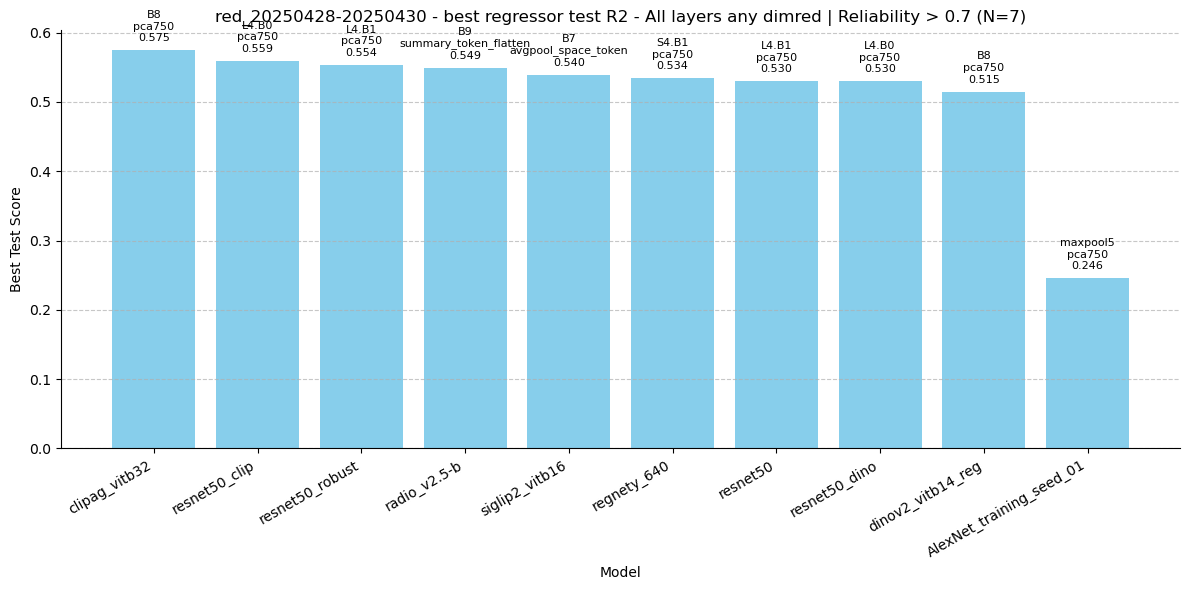

In [40]:
# Find the best layer/dimred/regressor combination for each model
best_per_model = top5_chan_result_df.groupby('modelname').apply(
    lambda x: x.loc[x['test_score'].idxmax()]
).reset_index(drop=True)
# Generate and display the figure
fig = plot_best_per_model(best_per_model, f"{subject_id} - best regressor test R2 - All layers any dimred | Reliability > {threshold} (N={channel_mask.sum()})")
saveallforms(synopsis_dir, f"{subject_id}_model_comparison_best_anydimred", fig)
plt.show()

In [10]:
# Use the function with reliability threshold
reliability = data_dict['reliability']
# Select top 5 channels with highest reliability
threshold = None  # Not using threshold-based selection
sorted_indices = np.argsort(reliability)[::-1]  # Sort in descending order
top5_indices = sorted_indices[:5]  # Take top 5 indices
channel_mask = np.zeros_like(reliability, dtype=bool)
channel_mask[top5_indices] = True
threshold = min(reliability[top5_indices])
top5_chan_result_df = sweep_combine_result_df(model_output_dir, subject_id, channel_mask)
top5_chan_result_df.to_csv(join(synopsis_dir, f"{subject_id}_top5_chan_all_models_result_df_synopsis_reliability_{threshold}.csv"))

/tmp/ipykernel_833776/1928200111.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_per_model = top5_chan_result_df.query("'pca750' in dimred").groupby('modelname').apply(


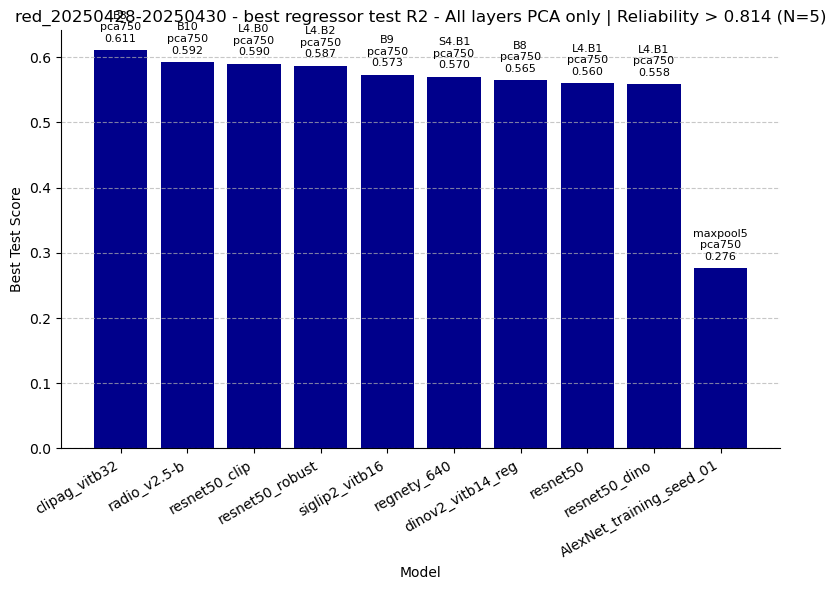

In [17]:
# Find the best layer/dimred/regressor combination for each model
best_per_model = top5_chan_result_df.query("'pca750' in dimred").groupby('modelname').apply(
    lambda x: x.loc[x['test_score'].idxmax()]
).reset_index(drop=True)
# Generate and display the figure
fig = plot_best_per_model(best_per_model, f"{subject_id} - best regressor test R2 - All layers PCA only | Reliability > {threshold:.3f} (N={channel_mask.sum()})", 
                          figsize=(8,6), color="darkblue")
saveallforms(synopsis_dir, f"{subject_id}_model_comparison_best_pca750_edit", fig)
plt.show()

/tmp/ipykernel_833776/3316154966.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_per_model = top5_chan_result_df.query("'pca750' in dimred").groupby('modelname').apply(


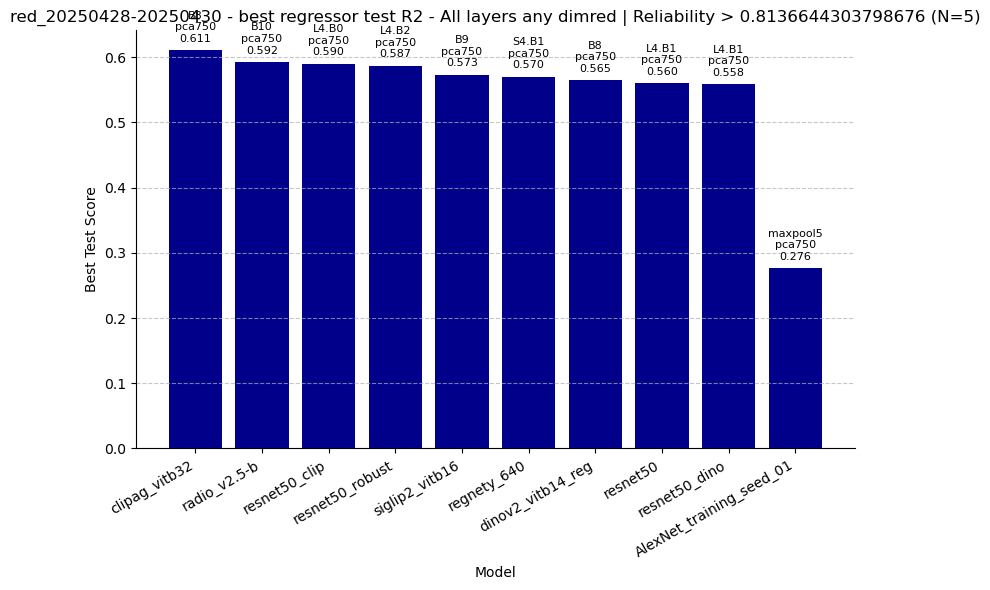

In [19]:
# Find the best layer/dimred/regressor combination for each model
best_per_model = top5_chan_result_df.query("'pca750' in dimred").groupby('modelname').apply(
    lambda x: x.loc[x['test_score'].idxmax()]
).reset_index(drop=True)
# Generate and display the figure
fig = plot_best_per_model(best_per_model, f"{subject_id} - best regressor test R2 - All layers any dimred | Reliability > {threshold} (N={channel_mask.sum()})",
                          figsize=(8,6), color="darkblue")
saveallforms(synopsis_dir, f"{subject_id}_model_comparison_best_anydimred_edit", fig)
plt.show()

/tmp/ipykernel_1059687/2924959490.py:59: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


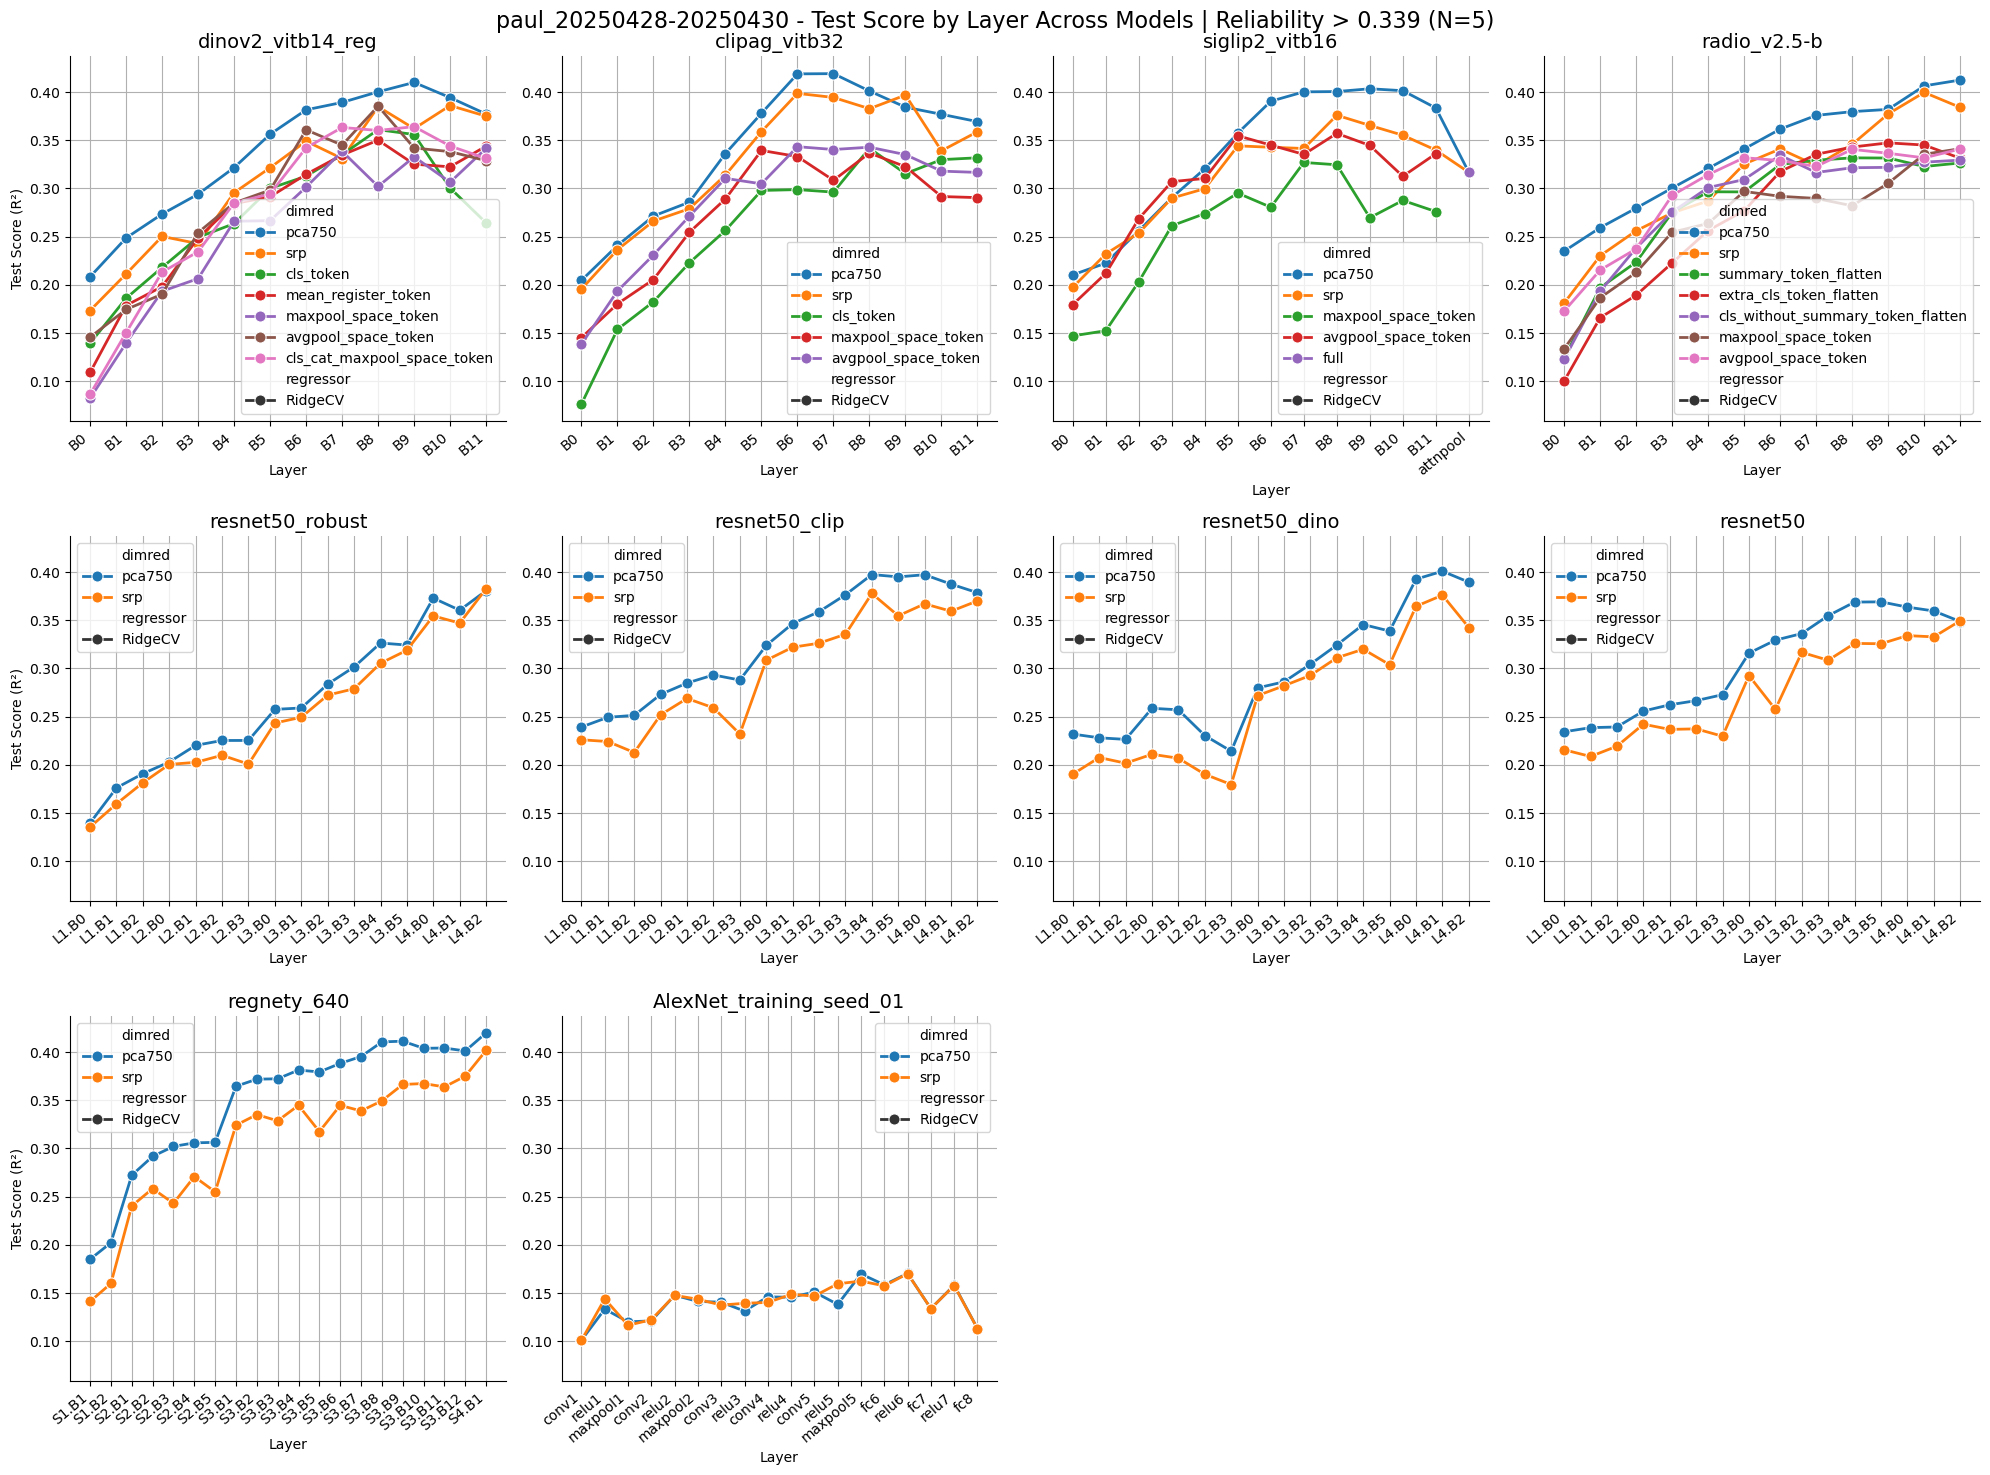

In [82]:
# Example usage:
fig = plot_model_layer_comparison(top5_chan_result_df, f"{subject_id} - Test Score by Layer Across Models | Reliability > {threshold:.3f} (N={channel_mask.sum()})")
saveallforms(synopsis_dir, f"{subject_id}_all_models_comparison_by_layer", fig)
plt.show()

/tmp/ipykernel_1059687/2304022590.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


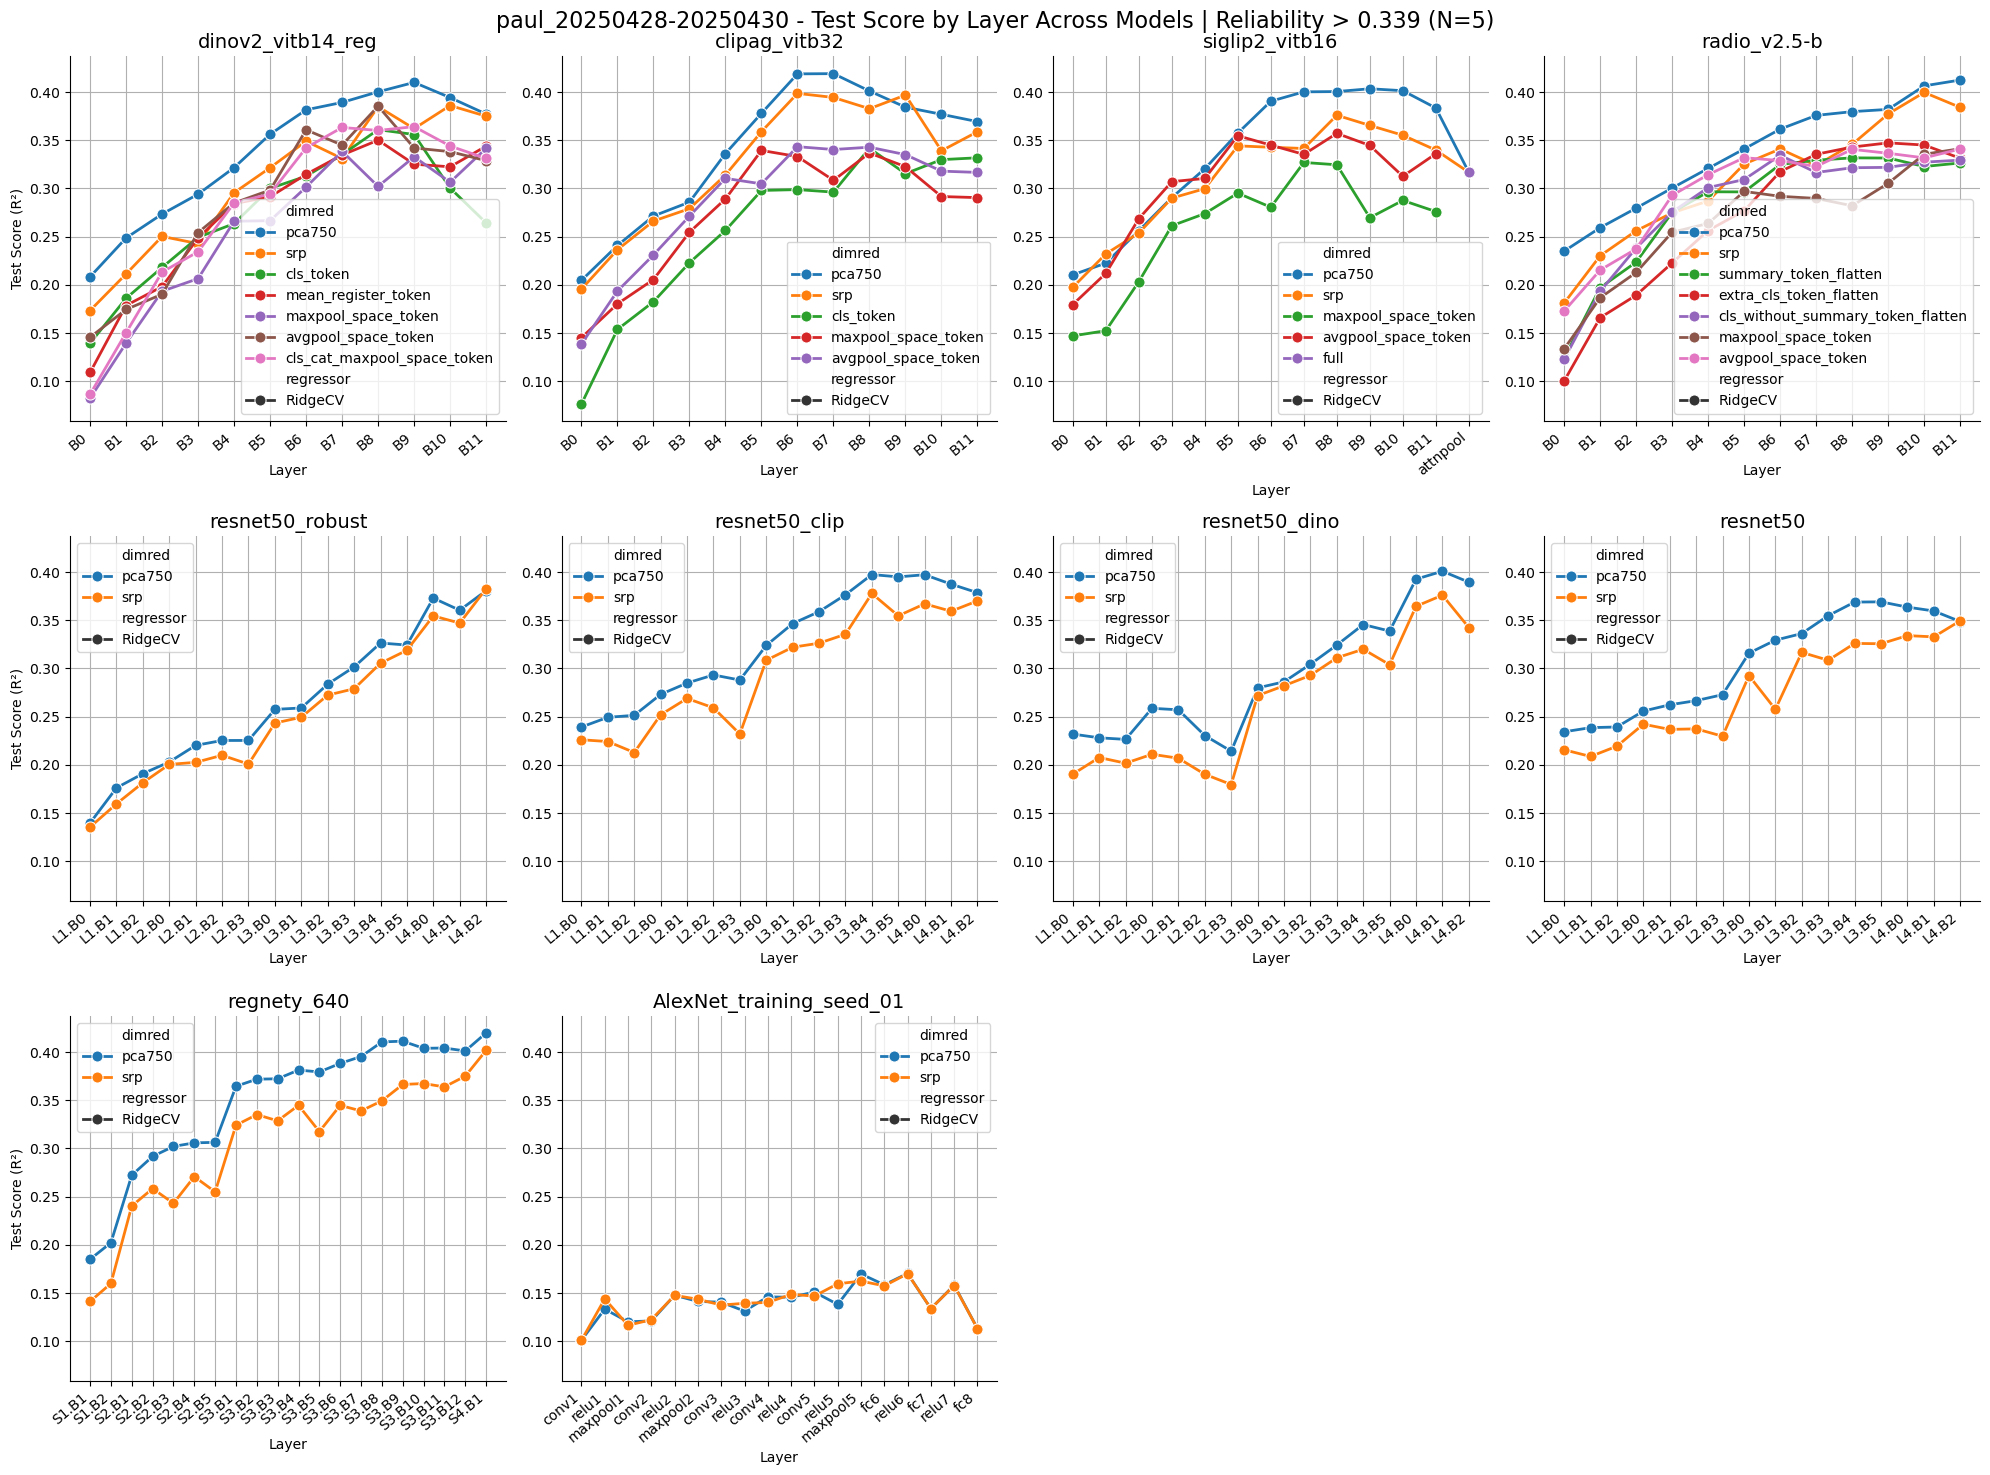

In [75]:
# Create a multi-panel figure with one subplot per model showing test score as function of layer
fig, axes = plt.subplots(3, 4, figsize=(20, 15), constrained_layout=True, sharey='all')
axes = axes.flatten()
# Get unique models
models = top5_chan_result_df['modelname'].unique()
# Plot each model in its own subplot
for i, model in enumerate(models):
    if i >= len(axes):  # Skip if we have more models than subplots
        break
    ax = axes[i]
    sns.lineplot(
        data=top5_chan_result_df.query("modelname == @model"),
        x='layer_abbrev', y='test_score', hue='dimred', style='regressor',
        marker='o', markersize=8, linewidth=2,
        ax=ax, 
    )
    ax.grid(True)
    ax.set_title(model, fontsize=14)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Test Score (R²)')
    # Ensure y-axis ticks are visible
    ax.tick_params(axis='y', which='both', left=True, labelleft=True)
    # ax.set_ylim(0, layer_scores['test_score'].max() * 1.1)  # Add 10% padding
    # rotate and align in one go
    ax.tick_params(axis='x', rotation=40)        # rotate them
    for lbl in ax.get_xticklabels():             # grab the Text objects
        lbl.set_ha('right')                      # set horizontal alignment

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle(f"{subject_id} - Test Score by Layer Across Models | Reliability > {threshold:.3f} (N={channel_mask.sum()})", 
             fontsize=16, y=0.98)
plt.tight_layout()
# Save the figure
# saveallforms(synopsis_dir, f"{subject_id}_model_comparison_by_layer", fig)
# Display the figure
plt.show()

### Other monkeys

In [50]:
# Use the function with reliability threshold

subject_id, filename = "paul_20250428-20250430", "paul_20250428-20250430_vvs-encodingstimuli_z1_rw100-400.h5"
data_path = join(dataroot, filename)
data_dict = extract_neural_data_dict_2025apr(load_from_hdf5(data_path))
reliability = data_dict['reliability']
# Get the top 5 channels with highest reliability
topk = 5
topk_indices = np.argsort(reliability)[-topk:]
# Create a binary mask for these top 5 channels
channel_mask = np.zeros_like(reliability, dtype=bool)
channel_mask[topk_indices] = True
# Report the threshold as the lowest reliability value among the top 5
threshold = reliability[topk_indices].min()
print(f"Using top 5 channels with reliability threshold: {threshold:.3f}")

model_output_dir = join(model_root, subject_id, "model_outputs_pca4all")
synopsis_dir = join(model_root, subject_id, "synopsis")
os.makedirs(synopsis_dir, exist_ok=True)
top5_chan_result_df = sweep_combine_result_df(model_output_dir, subject_id, channel_mask)
top5_chan_result_df.to_csv(join(synopsis_dir, f"{subject_id}_top5_chan_all_models_result_df_synopsis_reliability_{threshold}.csv"))

Using top 5 channels with reliability threshold: 0.339


/tmp/ipykernel_1059687/987050118.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_per_model = top5_chan_result_df.query("'pca750' in dimred").groupby('modelname').apply(


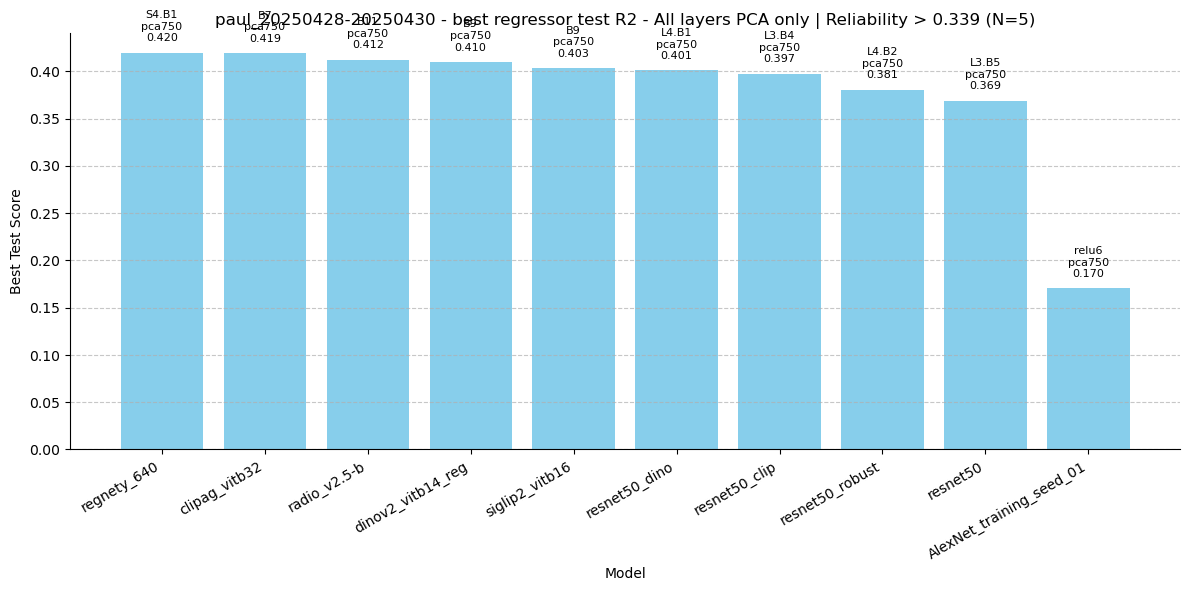

In [53]:
# Find the best layer/dimred/regressor combination for each model
best_per_model = top5_chan_result_df.query("'pca750' in dimred").groupby('modelname').apply(
    lambda x: x.loc[x['test_score'].idxmax()]
).reset_index(drop=True)
# Generate and display the figure
fig = plot_best_per_model(best_per_model, f"{subject_id} - best regressor test R2 - All layers PCA only | Reliability > {threshold:.3f} (N={channel_mask.sum()})")
saveallforms(synopsis_dir, f"{subject_id}_model_comparison_best_pca750", fig)
plt.show()

/tmp/ipykernel_1059687/2144710369.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_per_model = top5_chan_result_df.groupby('modelname').apply(


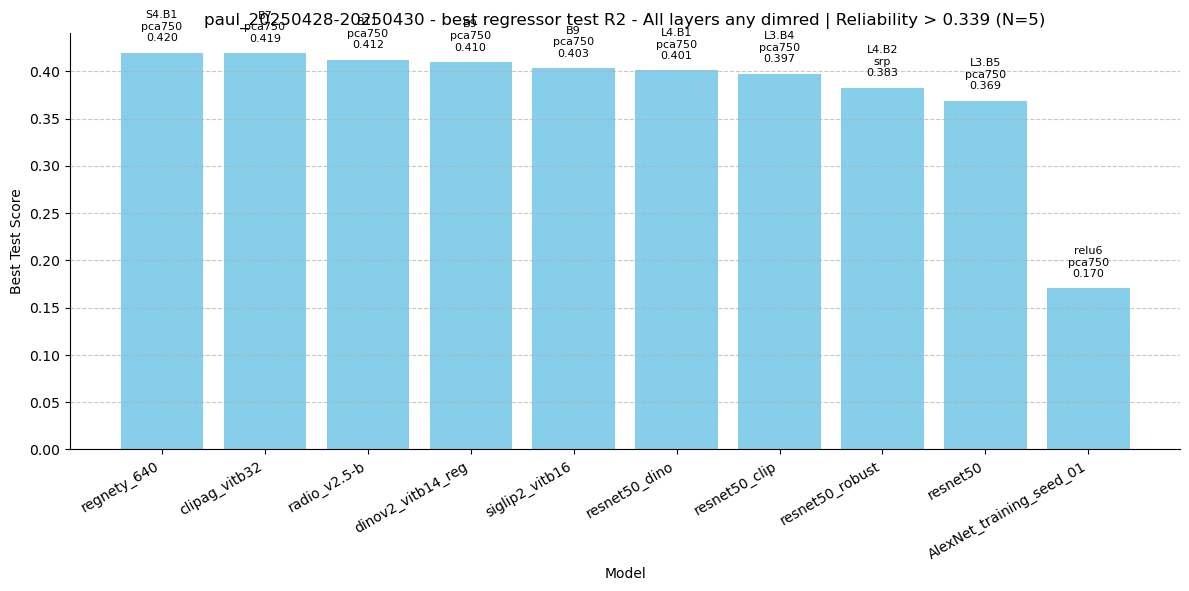

In [54]:
# Find the best layer/dimred/regressor combination for each model
best_per_model = top5_chan_result_df.groupby('modelname').apply(
    lambda x: x.loc[x['test_score'].idxmax()]
).reset_index(drop=True)
# Generate and display the figure
fig = plot_best_per_model(best_per_model, f"{subject_id} - best regressor test R2 - All layers any dimred | Reliability > {threshold:.3f} (N={channel_mask.sum()})")
saveallforms(synopsis_dir, f"{subject_id}_model_comparison_best_anydimred", fig)
plt.show()

### Obsolete figures from yesterday 0430

/tmp/ipykernel_782647/1808265271.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_per_model = top5_chan_result_df.groupby('modelname').apply(


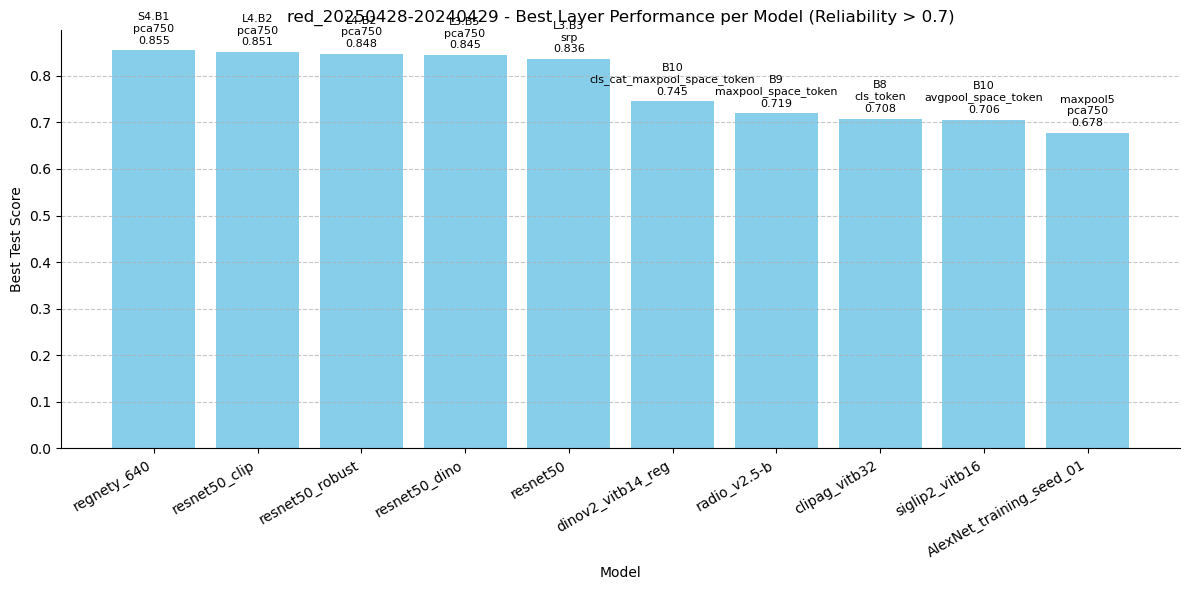

In [52]:
# Find the best layer/dimred/regressor combination for each model
best_per_model = top5_chan_result_df.groupby('modelname').apply(
    lambda x: x.loc[x['test_score'].idxmax()]
).reset_index(drop=True)

# Sort by test_score for better visualization
best_per_model = best_per_model.sort_values('test_score', ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(best_per_model['modelname'], best_per_model['test_score'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Best Test Score')
plt.title(f'{subject_id} - Best Layer Performance per Model (Reliability > 0.7)')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add the best layer/dimred info as text on top of each bar
for i, bar in enumerate(bars):
    layer = best_per_model.iloc[i]['layer_abbrev']
    dimred = best_per_model.iloc[i]['dimred']
    score = best_per_model.iloc[i]['test_score']
    
    # Truncate layer name if too long
    if len(layer) > 20:
        layer = layer[:17] + "..."
        
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        bar.get_height() + 0.01, 
        f"{layer}\n{dimred}\n{score:.3f}", 
        ha='center', va='bottom', 
        fontsize=8, rotation=0
    )
plt.tight_layout()
plt.show()